# 🎓 **Taller 4.2: Taller de Métodos de clustering basados en particiones**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [38]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


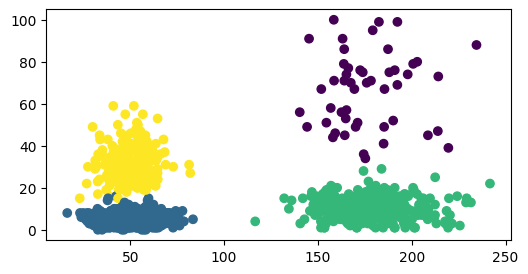

In [39]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **EJ 1:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [40]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[179.03629194  39.80398354]
 [157.7878323   59.79578008]
 [141.27700236  24.84856727]
 [ 51.02480682  82.18200335]]


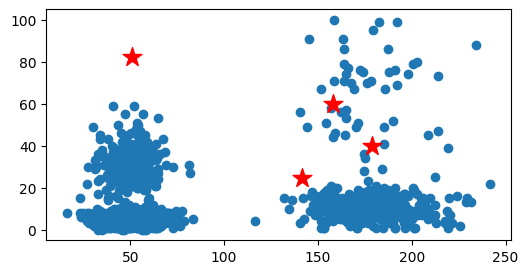

In [41]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [42]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

     distancia_punto_a_centros =  distancia_euclidiana_grupo(Dx[i],cDx) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
     pred_y = np.argmin(distancia_punto_a_centros)
     Dyp[i] = pred_y
  return Dyp

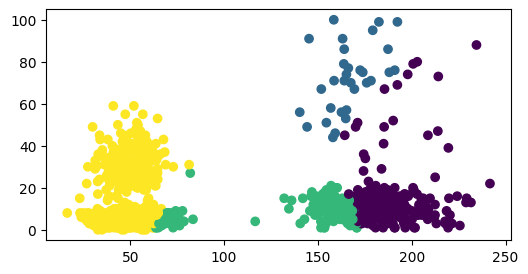

In [43]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [44]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

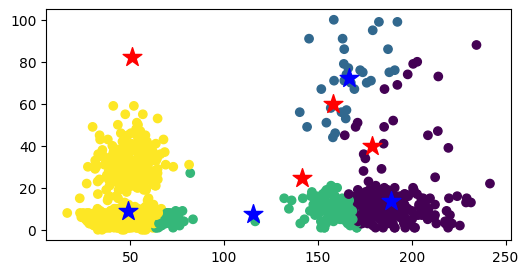

In [45]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [46]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx)# 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)# 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K)# 1.6 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

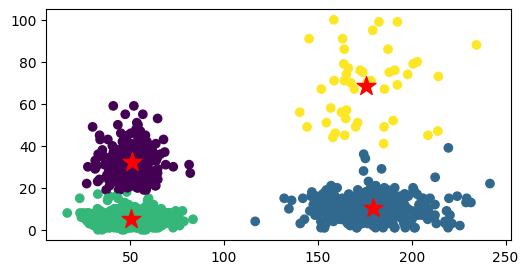

In [47]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: COMPARE SUS RESULTADOS CON SCIKIT-LEARN**

Centros encontrados por...
el método programado:
[[ 50.78213592  32.0776699 ]
 [179.3065043   10.59025788]
 [ 50.24671674   5.20600858]
 [175.6826087   68.36956522]]
el método de Sci-kit Learn:
[[ 50.24671674   5.20600858]
 [179.3065043   10.59025788]
 [ 50.78213592  32.0776699 ]
 [175.6826087   68.36956522]]


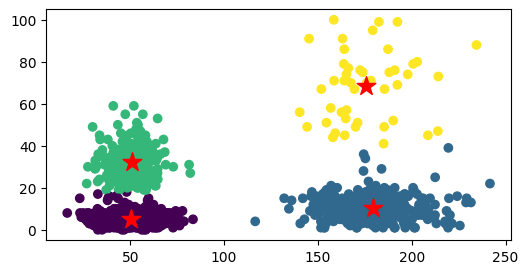

In [48]:
from sklearn.cluster import KMeans

# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=K, random_state=0, n_init='auto')
# Se entrena el modelo
modelo.fit(Dx)
# Se predice los clusters
Dyp_sk = modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print('Centros encontrados por...')
print('el método programado:')
print(cDx)
print('el método de Sci-kit Learn:')
print(cDx_sk)

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')

### 📈 **RESULTADOS:**
**Conteste las siguientes preguntas**

¿Porque difieren los grupos de sklearn con el algoritmo que tu implementaste?


Difieren principalmente por la estrategia de inicialización de los centroides.

1. Inicialización Aleatoria vs. K-Means++: Mi implementación utiliza una inicialización puramente aleatoria (random_sample_float), eligiendo puntos al azar dentro del rango de datos. En cambio, Scikit-Learn utiliza por defecto el método k-means++, el cual elige los centroides iniciales de manera inteligente (haciendo que estén lo más alejados posible entre sí) para acelerar la convergencia y mejorar la calidad final.

2. Mínimos Locales: El algoritmo K-Means es sensible a dónde empieza. Si los puntos iniciales están muy juntos, el algoritmo puede quedarse atrapado en un "mínimo local" (una solución subóptima), que es lo que probablemente pasó en mi implementación manual al ver que algunos centroides quedaron muy cerca unos de otros.

3. Repeticiones (n_init): Scikit-Learn ejecuta el algoritmo varias veces (parámetro n_init) con diferentes semillas y se queda con el mejor resultado (el que tiene menor inercia). Mi código solo lo ejecuta una vez, por lo que si la suerte no acompañó en la primera tirada, el resultado será peor.

# 🎯 **EJ 3: USA LAS METRICAS INTRINSECAS Y EXTRINSECAS PARA DECIDIR QUE TAN BIEN AGRUPADOS ESTAN LOS DATOS**

In [49]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(Dx, Dyp_sk)
print(silhouette_avg)

0.5900131037332426


In [50]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz_score_avg = calinski_harabasz_score(Dx, Dyp_sk)
print(calinski_harabasz_score_avg)

10596.232506708026


In [51]:
def medida_R_cuadrado(X, Xyp, cXs):
    centros_dataset = np.mean(X,axis=0)
    n_clusters = np.sort(np.unique(Xyp))
    distancia_a_centros_dataset = np.sum((X-centros_dataset)**2)
    distancias_intracluster = np.zeros(n_clusters.size)
    for k in np.arange(n_clusters.size):
        distancias_intracluster[k] = np.sum((X[Xyp==n_clusters[k], :] - cXs[n_clusters[k], :])**2)
    distancia_intracluster = np.sum(distancias_intracluster)
    # 3.3
    return 1 - (distancia_intracluster / distancia_a_centros_dataset)

In [52]:
# 3.4 usa R cuadrado
R_squared_score = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)
print(f"R-squared score: {R_squared_score}")

R-squared score: 0.9409478492159826


In [53]:
def calcular_inercia(X, labels, centros):
    inercia = 0
    for i, centro in enumerate(centros):
        puntos_cluster = X[labels == i]
        if len(puntos_cluster) > 0:
            distancias = np.sum((puntos_cluster - centro) ** 2, axis=1)
            inercia += np.sum(distancias)
    return inercia

In [54]:
#3.8 usa la inercia
inertia_score = calcular_inercia(Dx, Dyp_sk, cDx_sk)
print(f"Inertia score: {inertia_score}")

Inertia score: 346980.45098976814


### 📈 **RESULTADOS:**
**Interpreta con las medidas intrinsecas que tan bien agrupado estan los clusters**

Basado en los valores obtenidos con el modelo de Sklearn:

- Silhouette Score (~0.59): Este valor (en un rango de -1 a 1) indica una buena calidad de agrupamiento. Al ser 0.59, significa que los puntos están razonablemente cerca de su propio clúster y bastante lejos de los clústeres vecinos. No es perfecto (1.0), probablemente debido a las diferencias de densidad en los datos, pero es un resultado sólido.

- Calinski-Harabasz Score (~10596): Este índice es bastante alto. Dado que esta métrica premia la varianza entre grupos (separación) y penaliza la varianza dentro del grupo (cohesión), un valor tan alto confirma que los clústeres están bien definidos y separados entre sí.

- R-Cuadrado (~0.94): Este resultado es excelente. Indica que el modelo de clustering es capaz de explicar el 94% de la varianza de los datos. Es decir, la asignación de estos 4 centros captura casi toda la estructura de la distribución de los puntos.

- Inercia (~346,980): Aunque la inercia es un valor absoluto difícil de interpretar por sí solo (depende de la escala de los datos), en conjunto con el alto R-Cuadrado, sugiere que la suma de las distancias al cuadrado de las muestras a su centro más cercano se ha minimizado correctamente para este número de clústeres ($K=4$).

# 🚀 ¡TALLER FINALIZADO!"